### Loss, EP curves, AAL, Casualties

#### Asset values (synthetic but industry-realistic)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

# ============================================================
# LOAD DAMAGE SCENARIOS
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_damage_scenarios_evt.geojson"
)

print("Loaded facilities:", len(waste))

# ============================================================
# ASSET VALUES (₹ or $ — relative scale matters, not currency)
# ============================================================

ASSET_VALUE = {
    "wastewater_plant": 5e7,      # critical infrastructure
    "landfill": 2e7,
    "transfer_station": 1.5e7,
    "recycling": 1e7,
    "other": 1e7
}

DEFAULT_VALUE = 1e7

waste["asset_value"] = waste["facility_type"].map(ASSET_VALUE).fillna(DEFAULT_VALUE)

print("\nAsset value stats:")
print(waste["asset_value"].describe())


Loaded facilities: 16

Asset value stats:
count    1.600000e+01
mean     3.968750e+07
std      1.586072e+07
min      1.500000e+07
25%      2.000000e+07
50%      5.000000e+07
75%      5.000000e+07
max      5.000000e+07
Name: asset_value, dtype: float64


#### Compute loss per return period

In [2]:
# ============================================================
# LOSS CALCULATION
# ============================================================

rp_list = [2, 5, 10, 25, 50, 100]

for rp in rp_list:
    waste[f"loss_{rp}yr"] = (
        waste[f"damage_{rp}yr"] * waste["asset_value"]
    )

# Sanity check
print("\nLoss (100-yr) stats:")
print(waste["loss_100yr"].describe())



Loss (100-yr) stats:
count    1.600000e+01
mean     1.896559e+07
std      1.124235e+07
min      5.525868e+06
25%      7.855318e+06
50%      1.948185e+07
75%      2.438130e+07
max      3.875222e+07
Name: loss_100yr, dtype: float64


#### Portfolio loss table

In [3]:
# ============================================================
# PORTFOLIO LOSS SUMMARY
# ============================================================

portfolio_loss = []

for rp in rp_list:
    portfolio_loss.append({
        "return_period_years": rp,
        "portfolio_loss": waste[f"loss_{rp}yr"].sum()
    })

portfolio_df = pd.DataFrame(portfolio_loss)

print("\nPortfolio Loss Table:")
print(portfolio_df)

# Save
out_csv = "/vol/sandeep_storage/Files2/catastrophe/musi_portfolio_loss_evt.csv"
portfolio_df.to_csv(out_csv, index=False)
print("\nSaved:", out_csv)



Portfolio Loss Table:
   return_period_years  portfolio_loss
0                    2    8.781116e+07
1                    5    1.311051e+08
2                   10    1.650266e+08
3                   25    2.145842e+08
4                   50    2.566871e+08
5                  100    3.034495e+08

Saved: /vol/sandeep_storage/Files2/catastrophe/musi_portfolio_loss_evt.csv


In [1]:
import pandas as pd 
evt_loss= pd.read_csv('/vol/sandeep_storage/Files2/catastrophe/musi_portfolio_loss_evt.csv')
evt_loss


,return_period_years,portfolio_loss
0,2,8.781116e+07
1,5,1.311051e+08
2,10,1.650266e+08
3,25,2.145842e+08
4,50,2.566871e+08
5,100,3.034495e+08


#### EP curve (Return Period → Probability)

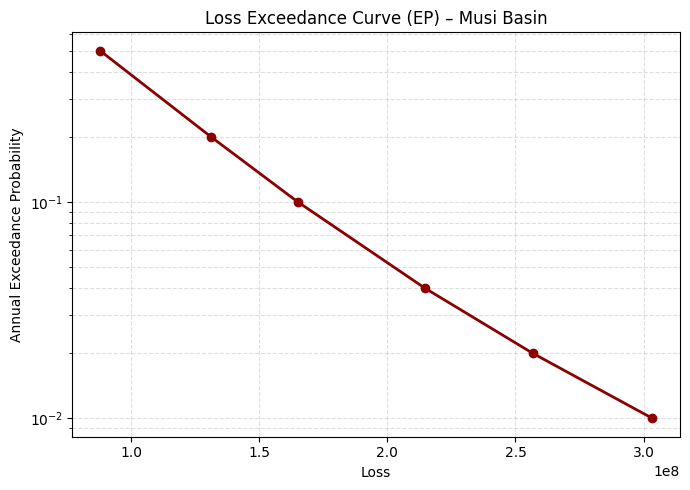

In [4]:
import matplotlib.pyplot as plt

portfolio_df["exceedance_prob"] = 1 / portfolio_df["return_period_years"]

plt.figure(figsize=(7, 5))

plt.plot(
    portfolio_df["portfolio_loss"],
    portfolio_df["exceedance_prob"],
    marker="o",
    linewidth=2,
    color="darkred"
)

plt.yscale("log")
plt.xlabel("Loss")
plt.ylabel("Annual Exceedance Probability")
plt.title("Loss Exceedance Curve (EP) – Musi Basin")
plt.grid(True, which="both", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


#### Average Annual Loss (AAL)

In [5]:
# ============================================================
# AAL CALCULATION
# ============================================================

portfolio_df = portfolio_df.sort_values("return_period_years")

AAL = 0.0
for i in range(len(portfolio_df) - 1):
    L1 = portfolio_df.iloc[i]["portfolio_loss"]
    L2 = portfolio_df.iloc[i + 1]["portfolio_loss"]
    p1 = 1 / portfolio_df.iloc[i]["return_period_years"]
    p2 = 1 / portfolio_df.iloc[i + 1]["return_period_years"]

    AAL += 0.5 * (L1 + L2) * (p1 - p2)

print(f"\nAverage Annual Loss (AAL): {AAL:,.2f}")



Average Annual Loss (AAL): 66,545,749.65


#### policy driven

#### casuality scenarios

In [6]:
import geopandas as gpd
import numpy as np

# ============================================================
# LOAD FACILITY EVT HAZARD SCENARIOS (NO POP HERE)
# ============================================================

hazard = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_scenarios_evt.geojson"
).to_crs(epsg=4326)

print("Loaded hazard facilities:", len(hazard))

# ============================================================
# LOAD POPULATION / EXPOSURE FILE
# ============================================================

pop = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_with_population.geojson"
).to_crs(epsg=4326)

print("Loaded population facilities:", len(pop))

# ------------------------------------------------------------
# Sanity check
# ------------------------------------------------------------
assert "population_density" in pop.columns, "Missing population_density!"
assert "pop_exposure" in pop.columns, "Missing pop_exposure!"

# ============================================================
# MERGE POPULATION INTO HAZARD FILE
# (Index-based is OK because these were derived from same base)
# ============================================================

hazard["population_density"] = pop["population_density"].values
hazard["pop_exposure"] = pop["pop_exposure"].values

# ============================================================
# CASUALTY CURVE PARAMETERS
# ============================================================

CASUALTY_PARAMS = {
    "wastewater_plant": {"c": 0.01, "gamma": 1.4},
    "transfer_station": {"c": 0.015, "gamma": 1.5},
    "recycling": {"c": 0.02, "gamma": 1.6},
    "landfill": {"c": 0.012, "gamma": 1.5},
    "other": {"c": 0.02, "gamma": 1.7},
}

DEFAULT_PARAMS = {"c": 0.015, "gamma": 1.5}

# ============================================================
# CASUALTY FUNCTION
# ============================================================

def casualty_fraction(hazard_intensity, c, gamma):
    """
    Fraction of exposed population affected
    """
    return np.clip(c * hazard_intensity**gamma, 0, 0.2)

# ============================================================
# APPLY CASUALTY MODEL PER RETURN PERIOD
# ============================================================

rp_cols = [
    "hazard_2yr",
    "hazard_5yr",
    "hazard_10yr",
    "hazard_25yr",
    "hazard_50yr",
    "hazard_100yr",
]

for col in rp_cols:
    cas_col = col.replace("hazard_", "casualties_")
    casualties = []

    for _, row in hazard.iterrows():
        ftype = row["facility_type"]
        params = CASUALTY_PARAMS.get(ftype, DEFAULT_PARAMS)

        frac = casualty_fraction(
            row[col],
            params["c"],
            params["gamma"]
        )

        # Absolute expected casualties (people)
        casualties.append(
            frac * row["population_density"]
        )

    hazard[cas_col] = casualties

# ============================================================
# SANITY CHECK
# ============================================================

print("\nCasualties (100-year) summary:")
print(hazard["casualties_100yr"].describe())

# ============================================================
# SAVE FINAL CASUALTY SCENARIO FILE
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_casualty_scenarios_evt.geojson"
)

hazard.to_file(out_path, driver="GeoJSON")

print("\nSaved casualty scenarios:", out_path)


Loaded hazard facilities: 16
Loaded population facilities: 16

Casualties (100-year) summary:
count    16.000000
mean      0.305242
std       0.176440
min       0.047329
25%       0.192307
50%       0.293570
75%       0.405611
max       0.616554
Name: casualties_100yr, dtype: float64

Saved casualty scenarios: /vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_casualty_scenarios_evt.geojson


In [7]:
hazard


,facility_type,dist_to_drainage_m,vuln_drainage,elevation_m,elev_percentile,vuln_elevation,slope_deg,slope_percentile,vuln_slope,flood_hazard_index,...,hazard_100yr,geometry,population_density,pop_exposure,casualties_2yr,casualties_5yr,casualties_10yr,casualties_25yr,casualties_50yr,casualties_100yr
0,wastewater_plant,1175.916986,0.764817,515.0,0.50000,0.50000,1.238635,0.93750,0.06250,0.531667,...,0.531667,POINT (78.46435 17.41619),52.445015,0.388421,0.059197,0.090182,0.114757,0.150980,0.181973,0.216571
1,wastewater_plant,159.951078,0.968010,502.0,0.25000,0.75000,0.699146,0.46875,0.53125,0.804354,...,0.804354,POINT (78.53388 17.3818),73.984283,0.547946,0.149095,0.227136,0.289032,0.380265,0.458325,0.545464
2,landfill,3187.375573,0.362525,495.0,0.12500,0.87500,0.972854,0.71875,0.28125,0.525636,...,0.525636,POINT (78.5822 17.35038),30.298679,0.224399,0.034522,0.054197,0.070164,0.094137,0.114985,0.138558
3,wastewater_plant,28.441820,0.994312,518.0,0.65625,0.34375,0.718740,0.62500,0.37500,0.642753,...,0.642753,POINT (78.57735 17.39818),54.960896,0.407054,0.080912,0.123264,0.156854,0.206365,0.248727,0.296016
4,transfer_station,168.646433,0.966271,528.0,0.93750,0.06250,0.448432,0.18750,0.81250,0.619197,...,0.619197,POINT (78.47969 17.41394),52.445015,0.388421,0.095499,0.149928,0.194096,0.260416,0.318087,0.383300
5,wastewater_plant,873.892710,0.825221,532.0,1.00000,0.00000,0.000000,0.09375,0.90625,0.552600,...,0.552600,POINT (78.47197 17.44359),137.080780,1.000000,0.163323,0.248812,0.316615,0.416555,0.502064,0.597519
6,wastewater_plant,303.693938,0.939261,526.0,0.87500,0.12500,0.984000,0.81250,0.18750,0.503918,...,0.503918,POINT (78.47839 17.43744),123.350273,0.913562,0.129164,0.196772,0.250394,0.329431,0.397055,0.472545
7,wastewater_plant,1211.262999,0.757747,493.0,0.06250,0.93750,0.972854,0.71875,0.28125,0.725361,...,0.725361,POINT (78.35948 17.41553),32.210739,0.238561,0.056166,0.085565,0.108882,0.143251,0.172657,0.205483
8,wastewater_plant,568.492664,0.886301,525.0,0.81250,0.18750,1.280363,1.00000,0.00000,0.464461,...,0.464461,POINT (78.5509 17.42333),71.058609,0.526277,0.066381,0.101127,0.128684,0.169303,0.204058,0.242854
9,landfill,2460.283916,0.507943,515.0,0.50000,0.50000,0.619390,0.25000,0.75000,0.553574,...,0.553574,POINT (78.37324 17.45976),30.911337,0.228937,0.038065,0.059759,0.077365,0.103799,0.126786,0.152779



Social EP Table:
   return_period  annual_exceedance_prob  portfolio_casualties
0              2                    0.50              1.304240
1              5                    0.20              2.001628
2             10                    0.10              2.558054
3             25                    0.04              3.382236
4             50                    0.02              4.090485
5            100                    0.01              4.883869


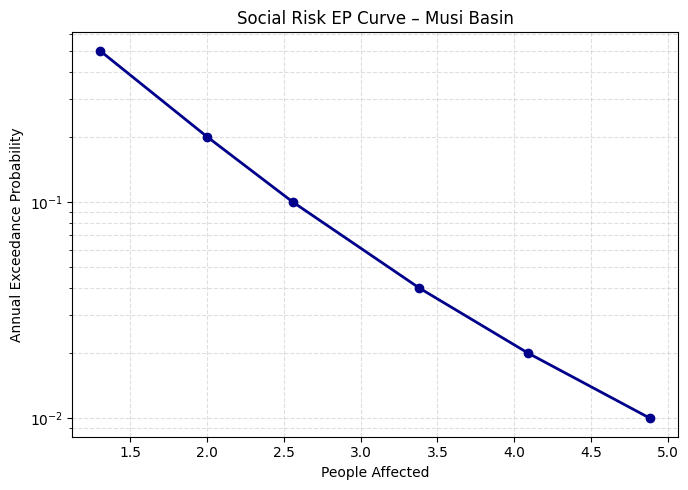

In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# LOAD CASUALTY SCENARIOS
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_casualty_scenarios_evt.geojson"
)

# ============================================================
# AGGREGATE PORTFOLIO CASUALTIES
# ============================================================

rp_cols = {
    2: "casualties_2yr",
    5: "casualties_5yr",
    10: "casualties_10yr",
    25: "casualties_25yr",
    50: "casualties_50yr",
    100: "casualties_100yr"
}

rows = []

for rp, col in rp_cols.items():
    rows.append({
        "return_period": rp,
        "annual_exceedance_prob": 1 / rp,
        "portfolio_casualties": waste[col].sum()
    })

social_ep = pd.DataFrame(rows).sort_values("portfolio_casualties")

print("\nSocial EP Table:")
print(social_ep)

# ============================================================
# PLOT SOCIAL EP CURVE
# ============================================================

plt.figure(figsize=(7, 5))

plt.plot(
    social_ep["portfolio_casualties"],
    social_ep["annual_exceedance_prob"],
    marker="o",
    linewidth=2,
    color="darkblue"
)

plt.yscale("log")
plt.xlabel("People Affected")
plt.ylabel("Annual Exceedance Probability")
plt.title("Social Risk EP Curve – Musi Basin")
plt.grid(True, which="both", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [9]:
import numpy as np

cas = social_ep.sort_values("annual_exceedance_prob", ascending=False)

eac = 0.0
for i in range(len(cas) - 1):
    c1 = cas.iloc[i]["portfolio_casualties"]
    c2 = cas.iloc[i + 1]["portfolio_casualties"]
    p1 = cas.iloc[i]["annual_exceedance_prob"]
    p2 = cas.iloc[i + 1]["annual_exceedance_prob"]
    eac += 0.5 * (c1 + c2) * (p1 - p2)

print(f"\nExpected Annual Casualties (EAC): {eac:.2f} people/year")



Expected Annual Casualties (EAC): 1.02 people/year


----